In [1]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


# _, term_width = os.popen('stty size', 'r').read().split()
# term_width = int(term_width)

try:
    _, term_width = os.popen('stty size', 'r').read().split()
    term_width = int(term_width)
except ValueError:  # Catch the error if terminal size cannot be determined
    term_width = 80  # Default width if actual size can't be determined


TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

stty: 'standard input': Inappropriate ioctl for device


Model

In [29]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        
#         self.linear = nn.Linear(512*block.expansion, num_classes)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

arguments

In [3]:
class Args:
    lr = 0.1
    resume = False

args = Args()


Main function

In [4]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Transformations for the validation dataset
transform_validation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [5]:
# /kaggle/input/cifar-10-batches-py/data_batch_1
root_dir = '/kaggle/input/cifar-10-batches-py'
train_files = [f'data_batch_{i}' for i in range(1, 6)]
validation_files = ['test_batch']

In [6]:
from torch.utils.data import Dataset
import pickle
import numpy as np

In [7]:
# Unpickle function
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
from PIL import Image

In [9]:
class CIFAR10Custom(Dataset):
    def __init__(self, data_paths, root_dir, transform=None):
        self.data = []
        self.targets = []
        for file_name in data_paths:
            file_path = os.path.join(root_dir, file_name)
            entry = unpickle(file_path)
            self.data.append(entry[b'data'])
            self.targets.extend(entry[b'labels'])
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))  # convert to HWC
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, target

In [10]:
train_dataset = CIFAR10Custom(train_files, root_dir=root_dir, transform=transform_train)

In [11]:
validation_dataset = CIFAR10Custom(validation_files, root_dir=root_dir, transform=transform_validation)

In [12]:
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2)

# DataLoader for the validation subset
validationloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=100, shuffle=False, num_workers=2)

In [30]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
# net = VGG('VGG19')
net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
# net = SimpleDLA()

net = net.to(device)
print('==> Completed Building model..')

==> Building model..
==> Completed Building model..


In [21]:
!pip install torchsummary
from torchsummary import summary

In [31]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

```
summary(net, input_size=(3, 32, 32))

Output:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128, 16, 16]             256
           Conv2d-15          [-1, 128, 16, 16]         147,456
      BatchNorm2d-16          [-1, 128, 16, 16]             256
           Conv2d-17          [-1, 128, 16, 16]           8,192
      BatchNorm2d-18          [-1, 128, 16, 16]             256
       BasicBlock-19          [-1, 128, 16, 16]               0
           Conv2d-20          [-1, 128, 16, 16]         147,456
      BatchNorm2d-21          [-1, 128, 16, 16]             256
           Conv2d-22          [-1, 128, 16, 16]         147,456
      BatchNorm2d-23          [-1, 128, 16, 16]             256
       BasicBlock-24          [-1, 128, 16, 16]               0
           Conv2d-25            [-1, 192, 8, 8]         221,184
      BatchNorm2d-26            [-1, 192, 8, 8]             384
           Conv2d-27            [-1, 192, 8, 8]         331,776
      BatchNorm2d-28            [-1, 192, 8, 8]             384
           Conv2d-29            [-1, 192, 8, 8]          24,576
      BatchNorm2d-30            [-1, 192, 8, 8]             384
       BasicBlock-31            [-1, 192, 8, 8]               0
           Conv2d-32            [-1, 192, 8, 8]         331,776
      BatchNorm2d-33            [-1, 192, 8, 8]             384
           Conv2d-34            [-1, 192, 8, 8]         331,776
      BatchNorm2d-35            [-1, 192, 8, 8]             384
       BasicBlock-36            [-1, 192, 8, 8]               0
           Conv2d-37            [-1, 256, 4, 4]         442,368
      BatchNorm2d-38            [-1, 256, 4, 4]             512
           Conv2d-39            [-1, 256, 4, 4]         589,824
      BatchNorm2d-40            [-1, 256, 4, 4]             512
           Conv2d-41            [-1, 256, 4, 4]          49,152
      BatchNorm2d-42            [-1, 256, 4, 4]             512
       BasicBlock-43            [-1, 256, 4, 4]               0
           Conv2d-44            [-1, 256, 4, 4]         589,824
      BatchNorm2d-45            [-1, 256, 4, 4]             512
           Conv2d-46            [-1, 256, 4, 4]         589,824
      BatchNorm2d-47            [-1, 256, 4, 4]             512
       BasicBlock-48            [-1, 256, 4, 4]               0
           Linear-49                   [-1, 10]           2,570
================================================================
Total params: 4,184,522
Trainable params: 4,184,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 10.50
Params size (MB): 15.96
Estimated Total Size (MB): 26.47
```

In [32]:
# net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [33]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Calculate average loss and accuracy over the epoch
    train_loss_avg = train_loss / len(trainloader.dataset)
    train_accuracy = 100. * correct / total
    return train_loss_avg, train_accuracy

In [34]:
def validate(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validationloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(validationloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
        
    # Calculate average loss and accuracy over the epoch
    val_loss_avg = test_loss / len(validationloader.dataset)
    val_accuracy = 100. * correct / total
    return val_loss_avg, val_accuracy

In [35]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
num_epochs = 200

for epoch in range(start_epoch, start_epoch+num_epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    
    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step()


Epoch: 0
 [================================================================>]  Step: 1s325ms | Tot: 19s633ms | Loss: 1.699 | Acc: 37.030% (18515/5000 391/391 
 [================================================================>]  Step: 15ms | Tot: 1s946ms | Loss: 1.443 | Acc: 46.650% (4665/1000 100/100 ========================>....................................]  Step: 29ms | Tot: 818ms | Loss: 1.447 | Acc: 47.311% (2129/450 45/100 ==============================>..................................]  Step: 14ms | Tot: 871ms | Loss: 1.442 | Acc: 47.479% (2279/480 48/100 ===============================================================>.]  Step: 24ms | Tot: 1s915ms | Loss: 1.441 | Acc: 46.755% (4582/980 98/100 
Saving..

Epoch: 1
 [================================================================>]  Step: 31ms | Tot: 18s258ms | Loss: 1.215 | Acc: 55.866% (27933/5000 391/391 
 [================================================================>]  Step: 13ms | Tot: 1s958ms | Loss: 1.078 | Acc: 

In [36]:
import matplotlib.pyplot as plt

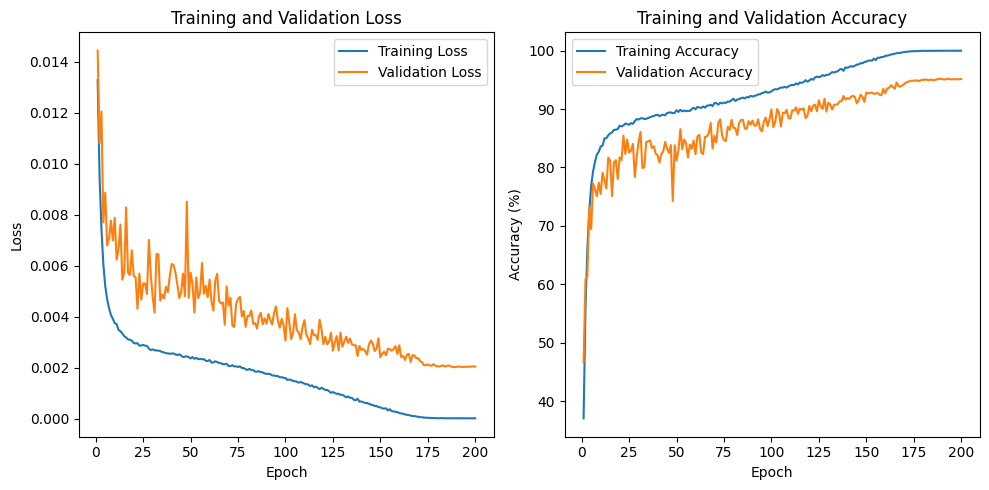

In [38]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
# Define a custom dataset class for the test dataset
class CIFAR10Test(Dataset):
    def __init__(self, file_path, transform=None):
        # Unpickle the test dataset file
        test_data_dict = unpickle(file_path)
        self.data = test_data_dict[b'data']
        self.ids = test_data_dict[b'ids']
        self.data = self.data.reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, self.ids[index]

In [41]:
test_file_path = '/kaggle/input/testdatanolabels/cifar_test_nolabels.pkl'

In [42]:
test_dataset = CIFAR10Test(file_path=test_file_path, transform=transform_validation)

In [43]:
len(test_dataset)

10000

In [45]:
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

In [46]:
len(testloader)

100

In [47]:
len(testloader.dataset)

10000

In [55]:
import pandas as pd

In [53]:
def generate_predictions():
    net.eval()  # Ensure the model is in evaluation mode
    predictions = []

    with torch.no_grad():
        for inputs, ids in testloader:
            inputs = inputs.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            
            # Collect the IDs and their corresponding predicted labels
            for id, label in zip(ids, predicted):
                predictions.append([id.item(), label.item()])

    # Convert predictions to a DataFrame and save as CSV
    df = pd.DataFrame(predictions, columns=['ID', 'Labels'])
    df.to_csv('predictions.csv', index=False)

In [56]:
generate_predictions()